### Predicting Intuition or Sensing

#### Load Packages

In [57]:
import requests
import pandas as pd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
palette='cubehelix'
pd.options.display.float_format = '{:,.3f}'.format


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=41)


import warnings
warnings.filterwarnings("ignore")

#### Fetch and read files into a dataframe

In [58]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer;
lemmatizer = WordNetLemmatizer()
#pd.read_csv('./')
df=pd.read_csv('../mbti_1.csv')


In [59]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [60]:
df.shape

(8675, 2)

In [61]:
df.dtypes


type     object
posts    object
dtype: object

In [62]:
df.isnull().sum()

type     0
posts    0
dtype: int64

In [63]:
df['type'].sort_values().head()

5777    ENFJ
7976    ENFJ
2851    ENFJ
342     ENFJ
1441    ENFJ
Name: type, dtype: object

#### Comparing the different personality types in the dataset
Note the imbalance of the volume of data by type. 

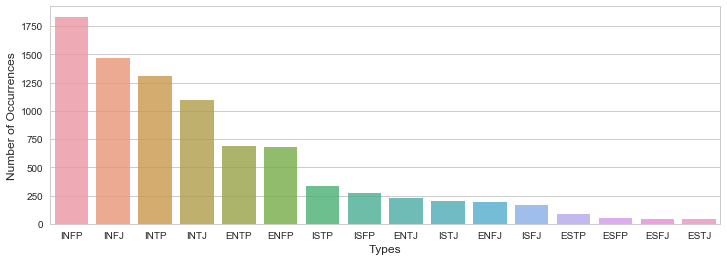

In [64]:
cnt_types = df['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

#### For separating out the four categories of personality

In [65]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E incorrect')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S incorrect')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F incorrect')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P incorrect')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

df1 = df.join(df.apply (lambda row: get_types (row),axis=1))



#### Distribution of data by 4 personality categories
Is much more balanced than the breakdown of the 16 MBTI types

In [66]:
print ('I=', df1['IE'].sum(), '0.769 of total IE')
print ('N=', df1['NS'].sum(), '0.862 of total NS')
print ('T=', df1['TF'].sum(), '0.459 of total TF')
print ('J=', df1['JP'].sum(), '0.396 of total JP')


I= 6676 0.769 of total IE
N= 7478 0.862 of total NS
T= 3981 0.459 of total TF
J= 3434 0.396 of total JP


In [67]:
df1.shape

(8675, 6)

In [68]:
#features = ['posts']
#X = df['posts']
#y = df['IE']
#y=df['NS']
#y=df['TF']
#y3=df['JP']

#y.head()
#X.head()

#### Coding for inputting Vader Sentiment analysis

In [69]:
# get our documents into a list for easy iteration
corpus = list(df['posts'])

In [70]:
#print(corpus[0])
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(corpus[0])

{'compound': 0.9816, 'neg': 0.057, 'neu': 0.832, 'pos': 0.111}

In [71]:

## get sentiment scores as list of dictionaries
list_dicts = []

# for each document in the corpus
for posts in corpus:
    #calculate sentiment
    scores = sia.polarity_scores(posts)
    #append that sentiment score dictionary to our list
    list_dicts.append(scores)

In [72]:

# create a dataframe out of the sentiment scores
df2 = pd.DataFrame(list_dicts)
df2.head()

,compound,neg,neu,pos
0,0.982,0.057,0.832,0.111
1,0.999,0.071,0.745,0.184
2,0.998,0.071,0.757,0.172
3,0.998,0.048,0.837,0.115
4,0.947,0.119,0.746,0.135


#### Merging new sentiment columns with others 

In [73]:
df = pd.concat(objs=[df1, df2], axis=1)
df.head()

,type,posts,IE,NS,TF,JP,compound,neg,neu,pos
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1,0.982,0.057,0.832,0.111
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0,0.999,0.071,0.745,0.184
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0,0.998,0.071,0.757,0.172
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1,0.998,0.048,0.837,0.115
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1,0.947,0.119,0.746,0.135


In [74]:
features = ['posts', 'compound', 'neg', 'neu', 'pos']
X = df[features]
#y = df['IE']
y=df['NS']
#y=df['TF']
#y3=df['JP']

#y.head()
#X.head()

#### Train Test Split

In [75]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
np.random.seed(41)

lr = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.3)
X_train.shape
#X_test.shape

(6072, 5)

#### NLP
CountVectorizer used to create numeric features from the posts.  Additional stop words were taken out as some personality related terms were in some postings.  

In [76]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = list(stopwords.words('english'))      
stop.extend(["stopwords_en.txt", "infjs", "infp", "infps", "intp", "intps",
                 "ixfp", "user", "ur", "traits", "understood", "isfp", "isfps",
                "istj", "istjs", "istps", "istp", "se", "yr", "si", "isfj", "isfjs", "infj", "infjs",
                "infj", "infjs", "intj", "intjs", "estp", "estps", "tritype", "nts", 
                "estj", "estjs", "esfp", "esfps", "esfj", "esfjs", "4w5", "24", "6w5", "5w4", "nt", 
                "entp", "entps", "entj", "entjs", "enfj", "niss", "sj", "trait", "enfjs", "enfp", "enfps", "introversion", 
                 "extroversion", "personalitycafe", "intuition", "sensing", "thinking", "feeling", "judging", "perceiving"])

stop=set(stop)
#new_stopwords = stop.union(new_words) 


In [77]:
corpus = X_train['posts']  # two docs in our corups
corpus1= X_test['posts']
## YOUR CODE HERE
from sklearn.feature_extraction.text import CountVectorizer
#Instantiate a CountVectorizor
cvec = CountVectorizer(stop_words=stop)
#cvec = CountVectorizer(stop)


#do X_test afterwards 
cvec.fit(corpus)
new_corpus = cvec.transform(corpus)
new_corpus1=cvec.transform(corpus1)

new_corpus.todense()
#new_corpus1.todense()
#df= pd.DataFrame(new_corpus.toarray(),
                   #columns=cvec.get_feature_names())

X_train_cv = pd.DataFrame(new_corpus.toarray(),
                   columns=cvec.get_feature_names())


X_test_cv = pd.DataFrame(new_corpus1.toarray(),
                   columns=cvec.get_feature_names())                   
#X_train_cv.shape
#X_test_cv.shape

In [78]:
X_train.shape

(6072, 5)

In [79]:
X_train_cv.shape

(6072, 115930)

#### Combining sentiment analysis features with newly created NLP features

In [80]:
features = ['compound', 'neg', 'neu', 'pos']
X1= X_train[features]
X2= X_test[features]
#y = df['IE']
#y=df['NS']
#y=df['TF']
#y=df['JP']
#df1=df[features]
X_train_cv1 = pd.concat(objs=[X1.reset_index(), X_train_cv.reset_index()], ignore_index=False, axis=1)
X_test_cv1 = pd.concat(objs=[X2.reset_index(), X_test_cv.reset_index()], ignore_index=False, axis=1)


In [81]:
#X_test_cv.shape
#X_train_cv1.head()
#X_train_cv1.drop(columns=['index'])
#X_test_cv1.drop(columns=['index'])

In [82]:
X_train_cv1.shape

(6072, 115936)

In [83]:
X1.shape

(6072, 4)

In [84]:
#X_train_cv1.head()

#### Logostic Regression Function 

In [85]:
## YOUR CODE HERE
from sklearn.linear_model import LogisticRegression, LinearRegression
np.random.seed(41)

from sklearn.model_selection import train_test_split

# Step 1: Instantiate our model.
logreg = LogisticRegression()

# Step 2: Fit our model.
logreg.fit(X_train_cv1, y_train)

print(logreg.score(X_train_cv1, y_train))
print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)


1.0
Logreg intercept: [0.37812535]
Logreg coef(s): [[1.97369479e-05 1.20727769e-01 2.43381090e-02 ... 2.03327654e-02
  5.65413887e-04 5.90606367e-04]]


In [86]:
np.random.seed(41)
logreg.score(X_test_cv1, y_test)
print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)
print(logreg.score(X_test_cv1, y_test))

Logreg intercept: [0.37812535]
Logreg coef(s): [[1.97369479e-05 1.20727769e-01 2.43381090e-02 ... 2.03327654e-02
  5.65413887e-04 5.90606367e-04]]
0.8501728774490972


In [1]:
from sklearn import linear_model
logreg.fit(X_test_cv1, y_test)

plt.scatter(X_test_cv1, y_test)
plt.plot(X_test_cv1, logreg.predict_proba(X_test_cv1)[:, 1], color="r")
plt.show()



NameError: name 'X_test_cv1' is not defined

#### Accuracy, Sensitivity, and Specificity

In [87]:
from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(y_test, logreg.predict(X_test_cv1))
print(confusion_matrix(y_test, logreg.predict(X_test_cv1)))
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

[[  95  272]
 [ 118 2118]]
Accuracy :  0.8501728774490972
Sensitivity :  0.25885558583106266
Specificity :  0.947227191413238


## Logreg Confusion Matrix
True Positive:      93
False Positive:     102
True Negative:     2134
False Negative:     272


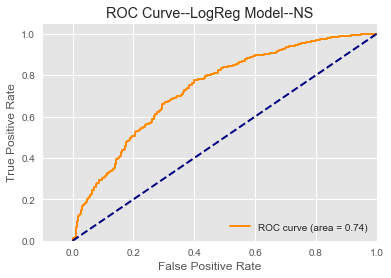

In [88]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


fpr, tpr, _ = roc_curve(y_test, logreg.decision_function(X_test_cv1))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve--LogReg Model--NS')
plt.legend(loc="lower right")
plt.show()

In [89]:
import requests, json, time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

#### Evaluating Feature Importance

In [90]:
feat_importance = pd.DataFrame(logreg.coef_.T, X_test_cv1.columns, columns=['importance'])

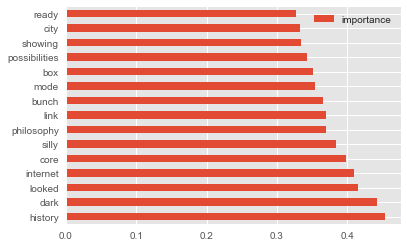

In [91]:
feat_importance.sort_values('importance', ascending=False).head(15).plot(kind='barh')

In [92]:
feat_importance.sort_values('importance', ascending=False).tail(15)

,importance
evanescence,-0.340
martial,-0.340
slow,-0.346
assumption,-0.350
break,-0.357
dominant,-0.363
practical,-0.368
driven,-0.371
car,-0.389
significant,-0.390


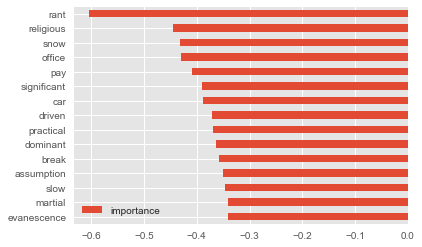

In [93]:
 feat_importance.sort_values('importance', ascending=False).tail(15).plot(kind='barh')

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

### Random Forest Model

In [38]:
np.random.seed(41)
dt = RandomForestClassifier(criterion='gini')
X1=X_train_cv1
y1=y_train
s = cross_val_score(dt, X1, y1, cv=cv)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.863 ± 0.0


In [39]:
dt.fit(X1, y1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
from sklearn.externals import joblib
joblib.dump(dt, 'JP.joblib')

['JP.joblib']

In [41]:
np.random.seed(41)
dt = RandomForestClassifier()
X2=X_test_cv1
y2=y_test
s = cross_val_score(dt, X2, y2, cv=cv)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.856 ± 0.002


### Extra Trees Classifier

In [42]:
np.random.seed(41)
dt1 = ExtraTreesClassifier()
s = cross_val_score(dt1, X1, y1, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees", s.mean().round(3), s.std().round(3)))

Extra Trees Score:	0.858 ± 0.002


In [43]:
np.random.seed(41)
dt1 = ExtraTreesClassifier()
s = cross_val_score(dt1, X2, y2, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees", s.mean().round(3), s.std().round(3)))

Extra Trees Score:	0.852 ± 0.002


### Multinomial GridSearchCV

In [44]:
cvec = CountVectorizer()
model = MultinomialNB()

In [45]:
pipe = Pipeline([
    ('cv', cvec),
    ('model', model)
])

In [46]:
np.random.seed(41)
params = {
    'cv__stop_words': [None, 'english'], 
    'cv__max_features': [2000, 3000, 4000],
    'cv__ngram_range': [(1, 1), (1, 2)],
    #'max_depth': np.arange(4, 10, 100),
    #'min_samples_split': [2, 10, 50],
    #'min_samples_leaf': [1, 16, 20, 25]
    #'criterion': ['gini', 'entropy'] 
    #'min_samples_leaf': [1, 10, 20],
    #'max_depth': [3, 6, 9, 12]
    }

In [47]:
gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train['posts'], y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'cv__stop_words': [None, 'english'], 'cv__max_features': [2000, 3000, 4000], 'cv__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
#y_train.shape
#X_train.shape

In [49]:
gs.best_params_

{'cv__max_features': 2000,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english'}

In [50]:
gs.best_score_

0.8400856389986825

In [51]:
gs.score(X_test['posts'], y_test)

0.8470995005762582